# Exercise: Visualization of Review Sentiment

In [11]:
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import Counter
import nltk
import spacy
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import string

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

cmap = ListedColormap([
    (0.894, 0.102, 0.110),
    (1.000, 0.498, 0.054),
    (0.121, 0.466, 0.705)
])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sangheon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Sangheon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sangheon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Steps 1-3: Preprocess review texts (spaCy lemmatization + NLTK stopword removal)
stop_words = set(stopwords.words('english'))

def remove_html(text_data):
    soup = BeautifulSoup(text_data, 'html.parser')
    return soup.get_text()

def remove_punctuation(text):
    sent = []
    for t in text.split(' '):
        no_punct = ''.join([c for c in t if c not in string.punctuation])
        sent.append(no_punct)

    sentence = " ".join([s for s in sent])
    return sentence

def preprocess_text_spacy(text):
    text = remove_html(text)
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    
    doc = nlp(text.strip())
    tokens = [(token.text, token.lemma_) for token in doc]

    rmv_sw_text = [w for w in tokens if (w not in stop_words) and (len(w) > 1)]

    return rmv_sw_text

In [13]:
df = pd.read_csv("week6_data/amazon_train_df.csv")

df['tokens'] = df['reviewText'].apply(preprocess_text_spacy)
ratings_raw = df.iloc[:, 1].values
ratings = np.where(ratings_raw >= 4, 1, np.where(ratings_raw == 3, 0, -1))

all_tokens = [token for tokens in df['tokens'] for token in tokens]
vocab = list(set(all_tokens))
vocab_index = {word: i for i, word in enumerate(vocab)}

print("Vocabulary size:", len(vocab))
print("Sample tokens:", list(vocab_index.items())[:10])

def text_to_onehot(tokens, vocab_index, vocab_size):
    vector = np.zeros(vocab_size)
    for token in tokens:
        if token in vocab_index:
            vector[vocab_index[token]] = 1
    return vector

one_hot_matrix = np.array([text_to_onehot(tokens, vocab_index, len(vocab)) for tokens in df['tokens']])

C:\Users\Sangheon\AppData\Local\Temp\ipykernel_40460\3065572371.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text_data, 'html.parser')


Vocabulary size: 4361
Sample tokens: [(('attractive', 'attractive'), 0), (('imagined', 'imagine'), 1), (('finished', 'finished'), 2), (('sale', 'sale'), 3), (('minor', 'minor'), 4), (('symbolthe', 'symbolthe'), 5), (('bagged', 'bag'), 6), (('   ', '   '), 7), (('cms', 'cms'), 8), (('door', 'door'), 9)]


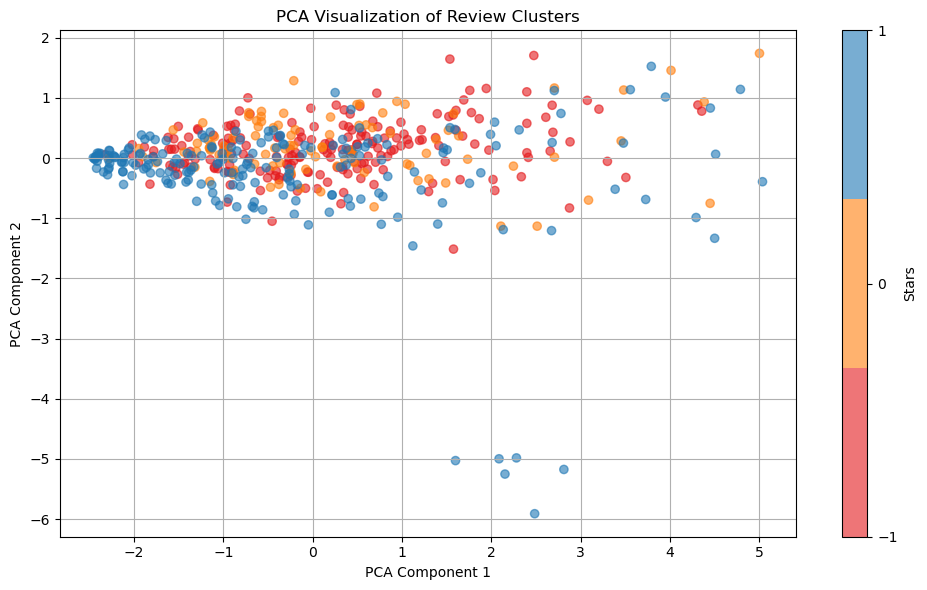

In [14]:
# Reduce dimension using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(one_hot_matrix)

# Visualize the clustering
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=ratings, cmap=cmap, alpha=0.6)
plt.title("PCA Visualization of Review Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Stars', ticks=[-1, 0, 1])
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd
import numpy as np
import re
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1. Load dataset
df = pd.read_csv("week6_data/amazon_reviews.csv")

# Step 2. Preprocess: lowercase, remove non-alphabetic, tokenize
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text.split()

df['tokens'] = df['REVIEW_TEXT'].astype(str).apply(preprocess)


In [16]:
# Step 3. Train Word2Vec with skip-gram (sg=1)
model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=2, sg=1, workers=4, seed=42)

In [17]:
# Step 4. Similar words
print("\nWords similar to 'need':")
print(model.wv.most_similar('need', topn=5))

print("\nWords similar to 'order':")
print(model.wv.most_similar('order', topn=5))

print("\nWords similar to 'package':")
print(model.wv.most_similar('package', topn=5))


Words similar to 'need':
[('want', 0.8215382099151611), ('wantbr', 0.7069175839424133), ('desire', 0.7043870687484741), ('wanna', 0.6879668235778809), ('intend', 0.6879491806030273)]

Words similar to 'order':
[('ordering', 0.7632409334182739), ('exchange', 0.7392222881317139), ('reorder', 0.7226172089576721), ('asap', 0.7189748287200928), ('requested', 0.716681718826294)]

Words similar to 'package':
[('packaging', 0.7938472628593445), ('mail', 0.7867368459701538), ('box', 0.7726688981056213), ('envelope', 0.7676371335983276), ('sealed', 0.7615329623222351)]


In [18]:
# Step 5. Word arithmetic examples
print("\nWord Arithmetic:")
print("bad - negative + good =",
      model.wv.most_similar(positive=['bad', 'good'],
                            negative=['negative'], topn=3))

print("father - man + woman =",
      model.wv.most_similar(positive=['father', 'woman'],
                            negative=['man'], topn=3))

print("apple - phone + laptop =",
      model.wv.most_similar(positive=['apple', 'laptop'],
                            negative=['phone'], topn=3))

print("book - wisdom + fun =",
      model.wv.most_similar(positive=['book', 'fun'],
                            negative=['wisdom'], topn=3))



Word Arithmetic:
bad - negative + good = [('decent', 0.6343621015548706), ('great', 0.5757758617401123), ('cool', 0.5608271956443787)]
father - man + woman = [('anniversary', 0.8114038109779358), ('yearold', 0.8088141679763794), ('granddaughter', 0.8062179088592529)]
apple - phone + laptop = [('wd', 0.7275675535202026), ('plasma', 0.7099592089653015), ('belkin', 0.6875413060188293)]
book - wisdom + fun = [('movie', 0.5782895684242249), ('game', 0.5445460081100464), ('story', 0.5221672654151917)]


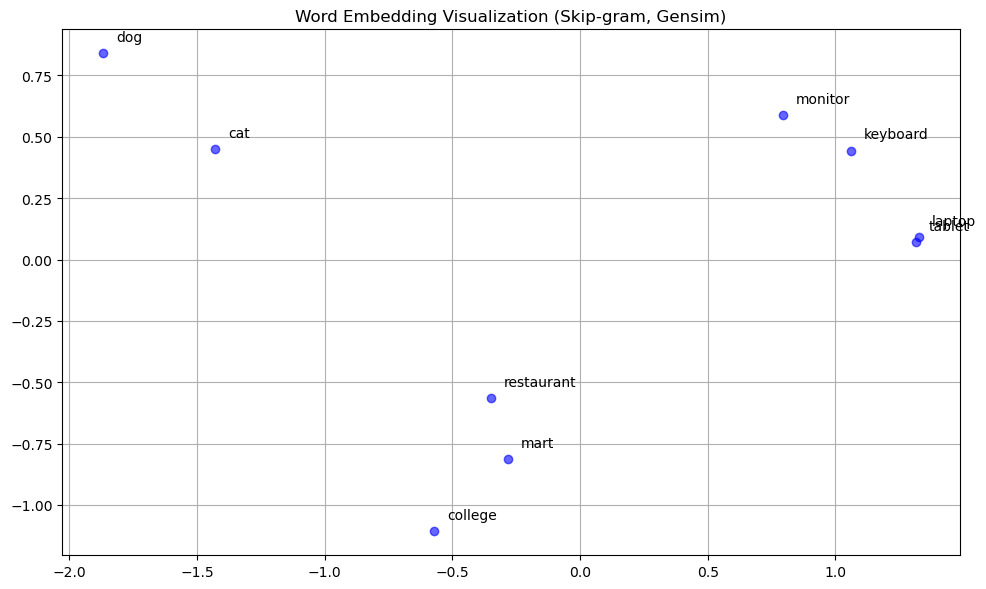

In [19]:
# Step 6. Embedding Visualization
def visualize_words(words, model):
    vectors = []
    labels = []
    for word in words:
        if word in model.wv:
            vectors.append(model.wv[word])
            labels.append(word)
    vectors = np.array(vectors)

    # PCA to 2D
    reduced = PCA(n_components=2).fit_transform(vectors)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c='blue', alpha=0.6)
    for i, label in enumerate(labels):
        plt.text(reduced[i, 0] + 0.05, reduced[i, 1] + 0.05, label, fontsize=10)
    plt.title("Word Embedding Visualization (Skip-gram, Gensim)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example groups for visualization
words = [
    'dog', 'laptop', 'tablet', 'mart',
    'keyboard', 'monitor', 'cat',
    'college', 'restaurant']
visualize_words(words, model)
